In [1]:
### The code for stylegan3
!git clone https://github.com/NVlabs/stylegan3.git

Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.17 MiB | 6.01 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [2]:
%cd stylegan3

/content/stylegan3


In [3]:
!pip install Ninja

     |████████████████████████████████| 108 kB 4.1 MB/s 


In [6]:
### Generate images with StyleGan2
!python gen_images.py --outdir=out/stylegan2 --trunc=1 --seeds=5 --network=https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-1024x1024.pkl


Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-1024x1024.pkl"...
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Traceback (most recent call last):
  File "gen_images.py", line 143, in <module>
    generate_images() # pylint: disable=no-value-for-parameter
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 782, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 1066, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 610, in invoke
    return callback(*args, **kwargs)
  File "gen_images.py", line 108, in generate_images
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
  File "/usr/local/lib/python3.7/dist-packages/torch

In [39]:
### Generate images with StyleGan3
!python gen_images.py --outdir=out/stylegan3 --trunc=1 --seeds=5 --network=https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl


Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl"...
Generating image for seed 5 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


In [45]:
### Calculate error metrics for the images generated from StyleGan2 and StyleGan3
!pip install lpips
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
# from skimage import data, img_as_float
import pandas as pd
import cv2
import lpips
import os
import torch
pd.options.mode.chained_assignment = None
loss_fn = lpips.LPIPS(net='alex')

img_path = '/content/stylegan3/out/stylegan2/seed0005.png'
ref_path = '/content/stylegan3/out/stylegan3/seed0005.png'


ref_img = cv2.imread(ref_path)
img = cv2.imread(img_path)

ref_img_ten = torch.tensor(ref_img.transpose([2,0,1])).unsqueeze(0)
img_ten = torch.tensor(img.transpose([2,0,1])).unsqueeze(0)
mse  = mean_squared_error(ref_img.reshape([-1]),img.reshape([-1]))
ssim= ssim(ref_img,img,data_range=img.max() - img.min(),multichannel=True)
lpips = loss_fn.forward(ref_img_ten,img_ten).item()

print(f"Mean squared error in pixel domain: {mse}")
print(f"Single scale structural similarity index: {ssim}")
print(f"Learned perceptual image patch similarity metric: {lpips}")


     |████████████████████████████████| 53 kB 2.0 MB/s 
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
Mean squared error in pixel domain: 105.73643398284912
Single scale structural similarity index: 0.2902083038898778
Learned perceptual image patch similarity metric: 0.4509508013725281


In [42]:
!pip install imgui

     |████████████████████████████████| 3.4 MB 14.5 MB/s 


In [43]:
!python visualizer.py

Traceback (most recent call last):
  File "visualizer.py", line 16, in <module>
    from gui_utils import imgui_window
  File "/content/stylegan3/gui_utils/imgui_window.py", line 11, in <module>
    import imgui.integrations.glfw
  File "/usr/local/lib/python3.7/dist-packages/imgui/integrations/glfw.py", line 4, in <module>
    import glfw
ModuleNotFoundError: No module named 'glfw'


In [29]:
# url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
# with dnnlib.util.open_url(url) as f:
#     _G, _D, Gs = pickle.load(f, encoding='latin1')
!pwd

/content/stylegan3


In [31]:
# !wget https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl

import pickle
import torch
import numpy as np
seed=5
url = "stylegan3-t-ffhq-1024x1024.pkl"
# url = "../stylegan2/stylegan2-ffhq-config-f.pkl"
with open(url, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module

# z = torch.randn([1, G.z_dim]).cuda() 
z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).cuda()    # latent codes
c = None                                # class labels (not used in this example)

w = G.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
img = G.synthesis(w, noise_mode='const', force_fp32=True)

# img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1], no truncation
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)

In [34]:
!pwd

/content/stylegan3


In [37]:
import PIL
from PIL import Image
PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save('seed17.png')
pil_im = Image.open('seed17.png')
# display(pil_im)



## Style Gan 2

In [1]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

!python run_generator.py generate-images --network=gdrive:networks/stylegan2-ffhq-config-f.pkl --seeds=5 --truncation-psi=0.5


TensorFlow 1.x selected.
fatal: destination path 'stylegan2' already exists and is not an empty directory.
/content/stylegan2
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.2
GPU 0: Tesla T4 (UUID: GPU-7f4846d0-9afd-1704-4bb5-9bfc397a007d)
GPU Identified at: /device:GPU:0
Local submit - run_dir: results/00000-generate-images
dnnlib: Running run_generator.generate_images() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Generating image for seed 5 (0/1) ...
dnnlib: Finished run_generator.generate_images() in 54s.


In [2]:
!wget http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl


--2022-04-27 11:37:28--  http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl
Resolving d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)... 18.66.9.61, 18.66.9.161, 18.66.9.65, ...
Connecting to d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)|18.66.9.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381673535 (364M) [application/x-www-form-urlencoded]
Saving to: ‘stylegan2-ffhq-config-f.pkl’

stylegan2-ffhq-conf 100%[===================>] 363.99M   131MB/s    in 2.8s    

2022-04-27 11:37:32 (131 MB/s) - ‘stylegan2-ffhq-config-f.pkl’ saved [381673535/381673535]



In [3]:
# Download the model of choice

import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks


network_pkl = "stylegan2-ffhq-config-f.pkl"
# network_pkl = "../karras2019stylegan-ffhq-1024x1024.pkl"



print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Loading networks from "stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [4]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )



In [25]:
generate_images_in_w_space(w.cpu(), truncation_psi=0.7)

InvalidArgumentError: ignored

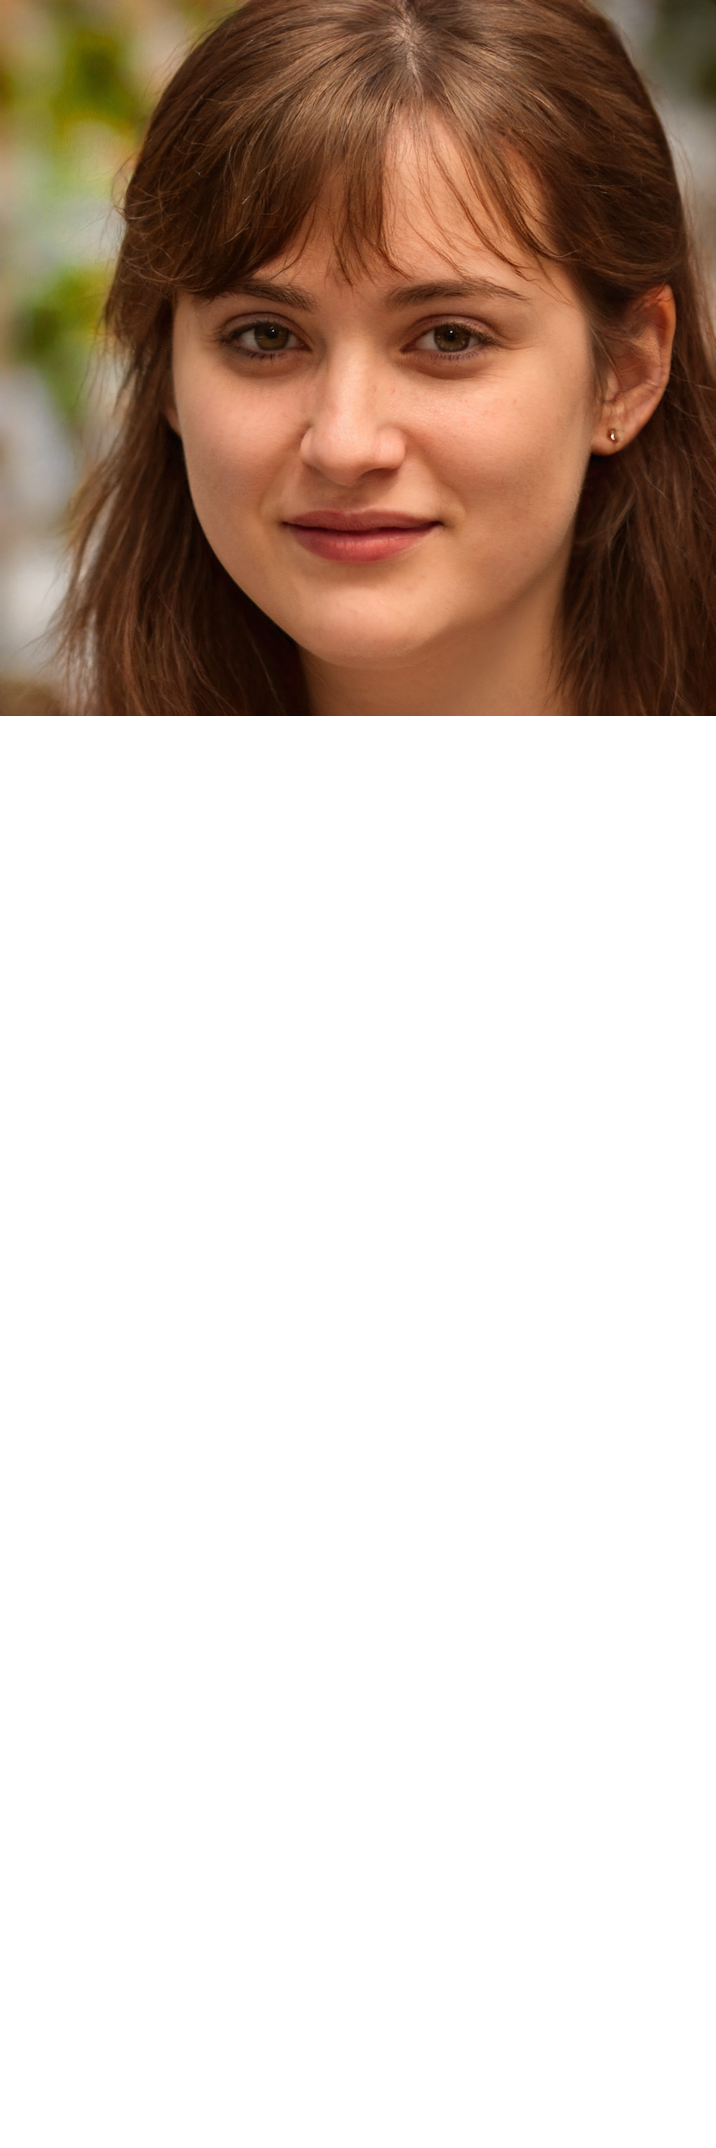

In [23]:
imshow(createImageGrid(generate_images([z.cpu()], 0.7), 0.7, 3))

[3 2 3]


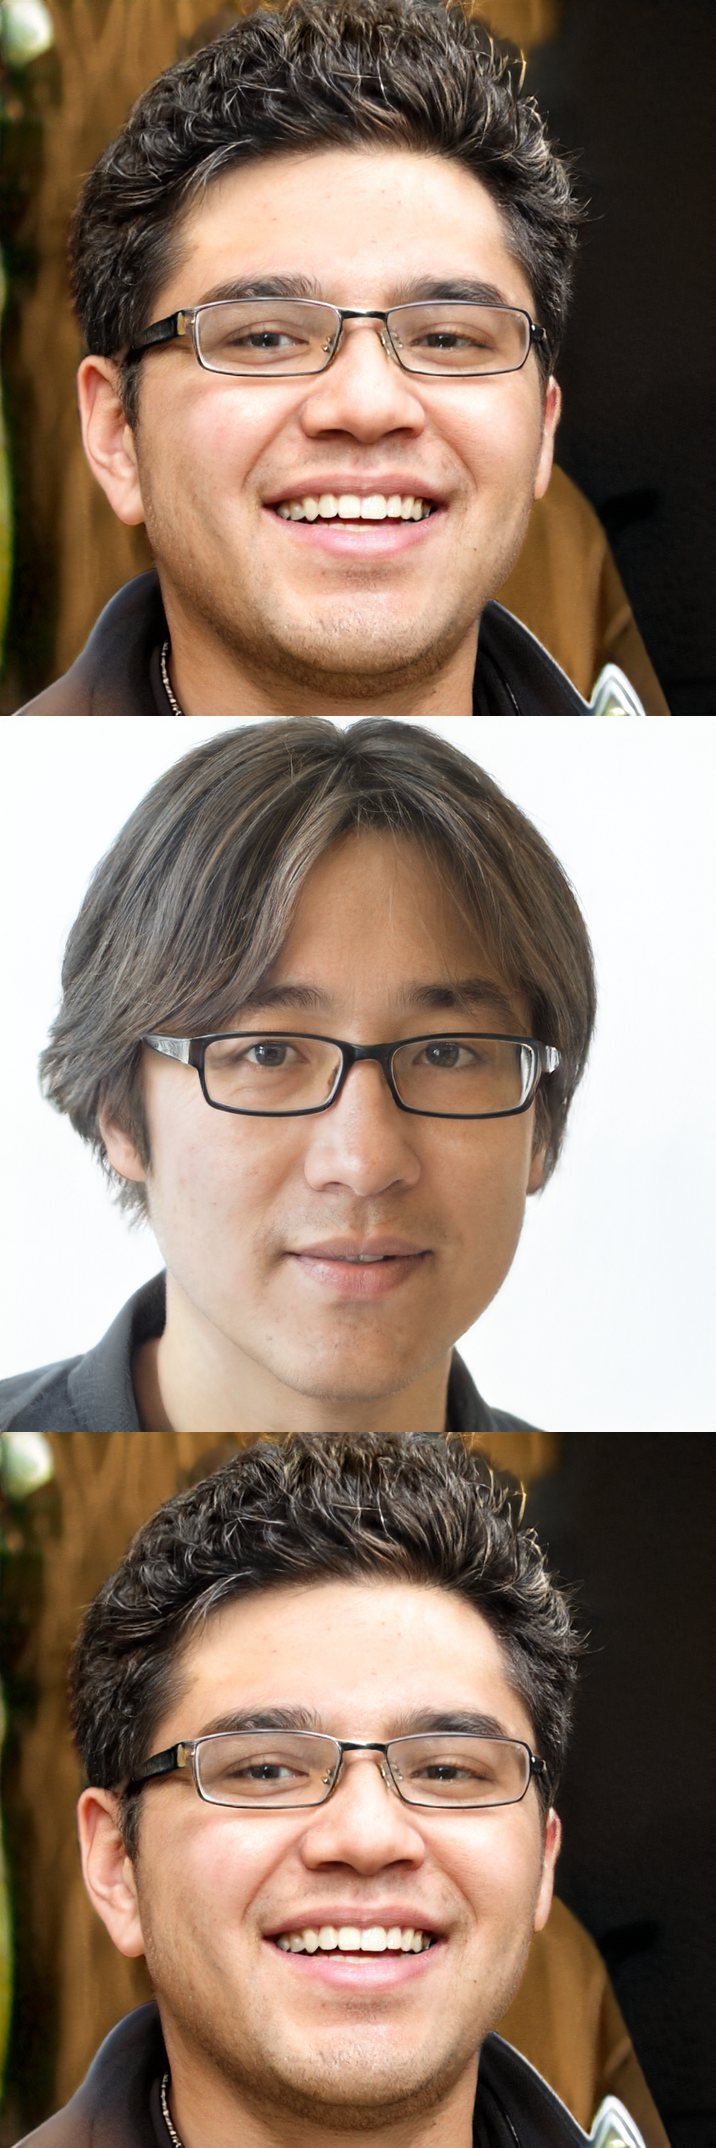

In [5]:
seeds = np.random.randint(5, size=3)
print(seeds)

# show the seeds
imshow(createImageGrid(generate_images_from_seeds(seeds, 0.7), 0.7 , 3))